![A Cloud Guru](acg_logo.png)
<hr/>

<center><h1>Hyperparameter Tuning Job Created Using Amazon SageMaker</h1></center>

# Introduction

In this lab, you will learn how to import the iris dataset, split it into training and validation data, upload them to S3 bucket, fetch the lienar learner algorithm, initialize the estimator object, and automatically tune the hyperparameters using Amazon SageMaker's Automatic Model Tuning (AMT).

# How to Use This Lab

Most of the code is provided for you in this lab as our solution to the tasks presented. Some of the cells are left empty with a #TODO header and its your turn to fill in the empty code. You can always use our lab guide if you are stuck.

# 1) Install dependencies and import the required libraries

In [1]:
# Install Sagemaker
!pip install -U sagemaker smdebug numpy==1.26.4 shap

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 6.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 1.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.3 MB/s eta 0:00:00:00:01
  Created wheel for pyinstrument-cext: filename=pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl size=6303 sha256=1d6b02fe497ecd39118e799e74f153d0589d79e5024ba5ed68a87c896f8c29b1
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0f/8b/7a/5f7fd1dd6d3cbb3d350d4c832c5e2f962687749f6d67d573a6
Successfully built pyinstrument-cext
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
  Attempting uninstall: shap
    Found exis

1. We will use the iris dataset as our input data. 
2. The S3 bucket that you want to use for training data must be within the same region as the Notebook Instance.
3. The IAM role arn is used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [2]:
import sagemaker
import boto3
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sagemaker.debugger import Rule, DebuggerHookConfig, CollectionConfig, rule_configs

# Initialize the SageMaker session
sagemaker_session = sagemaker.Session()

# Define the S3 bucket and prefix to store data
output_bucket = sagemaker.Session().default_bucket()
output_prefix = 'sagemaker/xgboost-debugger'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


In [3]:
#TODO: Fetch the IAM role using the get_execution_role function and assign the value to a variable `role`
# Get the IAM role
role = get_execution_role()

# 2) Download the data and upload them to S3 bucket

1. load_iris function is used to downlaod the input data
2. The data is split into training and validatin data in the ration of 80 - 20
3. The data is saved under 'train.csv' and 'validation.csv'

In [4]:
import shap

X, y = shap.datasets.adult()

In [5]:
#TODO: Use the `train_test_split` function and the split the data in a 80 - 20 ratio. 
#TODO: Assign the values to variables `train_data` and `validation_data` 
# Split into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)


In [6]:
train_data = pd.concat(
    [pd.Series(y_train, index=X_train.index, name="Train data", dtype=int), X_train],
    axis=1,
)
validation_data = pd.concat(
    [pd.Series(y_test, index=X_test.index, name="Validation data", dtype=int), X_test],
    axis=1,
)

In [7]:
# Save to CSV
train_data.to_csv('train.csv', index=False, header=False)
validation_data.to_csv('validation.csv', index=False, header=False)

Let's use the upload_file function and upload the .csv files to the S3 buckets

In [8]:
# Upload data to S3
s3 = boto3.client('s3')
s3.upload_file('train.csv', output_bucket, f'{output_prefix}/train/train.csv')

In [9]:
#TODO: Using the strategy we followed to upload the training data as shown above, please upload the validation data to the output bucket.
s3.upload_file('validation.csv', output_bucket, f'{output_prefix}/validation/validation.csv')

# 3) Set up training and validation data

Create three separate variables that is dynamically constructed which will be used as one of the input parameters while generating training inputs

In [10]:
# creating the inputs for the fit() function with the training and validation location
s3_train_data = f"s3://{output_bucket}/{output_prefix}/train"
print(f"training files will be taken from: {s3_train_data}")
s3_validation_data = f"s3://{output_bucket}/{output_prefix}/validation"
print(f"validation files will be taken from: {s3_validation_data}")
output_location = f"s3://{output_bucket}/{output_prefix}/output"
print(f"training artifacts output location: {output_location}")

training files will be taken from: s3://sagemaker-us-east-1-247900453419/sagemaker/xgboost-debugger/train
validation files will be taken from: s3://sagemaker-us-east-1-247900453419/sagemaker/xgboost-debugger/validation
training artifacts output location: s3://sagemaker-us-east-1-247900453419/sagemaker/xgboost-debugger/output


Let's create the sagemaker.session.s3_input objects from our data channels. Note that we are using the content_type as text/csv. We use two channels here one for training and the second one for validation.

In [11]:
# generating the session.s3_input() format for fit() accepted by the sdk
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)

In [12]:
#TODO: Following the same strategy as shown above, please set up a training input for validation data.
#TODO: Name it as `validation_data`
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)

# 4) Fetch the algorithm and initialize estimator

Let's retrieve the image for the Linear Learner Algorithm according to the region.

In [13]:
# getting the linear learner image according to the region
from sagemaker.image_uris import retrieve

container = retrieve('xgboost', boto3.Session().region_name, version='1.2-1')
print(container)
deploy_amt_model = True

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1


Then we create an estimator from the SageMaker Python SDK using the Linear Learner container image and we setup the training parameters 

In [14]:
hyperparameters = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.7",
    "objective": "binary:logistic",
    "num_round": "51",
}

save_interval = 5

In [15]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator
from time import gmtime, strftime

job_name = "xgboost-iris-debugger-" + strftime("%Y%m%d-%H-%M-%S", gmtime())
print("Training job", job_name)

xgboost_estimator = Estimator(
    role=role,
    base_job_name=job_name,
    instance_count=1,
    instance_type="ml.m5.large",
    image_uri=container,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=output_location,  # Required
        collection_configs=[
            CollectionConfig(name="metrics", parameters={"save_interval": str(save_interval)}),
            CollectionConfig(
                name="feature_importance",
                parameters={"save_interval": str(save_interval)},
            ),            
        ],
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        ),
    ],
)

Training job xgboost-iris-debugger-20240806-16-35-04


In [16]:
xgboost_estimator.fit({"train": train_data, "validation": validation_data}, wait=False)

INFO:sagemaker:Creating training-job with name: xgboost-iris-debugger-20240806-16-35-04-2024-08-06-16-35-13-945


In [18]:
job_name = xgboost_estimator.latest_training_job.name
print("Training job name: {}".format(job_name))

Training job name: xgboost-iris-debugger-20240806-16-35-04-2024-08-06-16-35-13-945


In [21]:
import time

client = xgboost_estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=job_name)
if description["TrainingJobStatus"] != "Completed":
    while description["SecondaryStatus"] not in {"Training", "Stopped", "Completed", "Failed"}:
        description = client.describe_training_job(TrainingJobName=job_name)
        primary_status = description["TrainingJobStatus"]
        secondary_status = description["SecondaryStatus"]
        print(
            "Current job status: [PrimaryStatus: {}, SecondaryStatus: {}] | {} Rule Evaluation Status: {}".format(
                primary_status,
                secondary_status,
                xgboost_estimator.latest_training_job.rule_job_summary()[0]["RuleConfigurationName"],
                xgboost_estimator.latest_training_job.rule_job_summary()[0]["RuleEvaluationStatus"],
            )
        )
        time.sleep(30)

Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Downloading] | LossNotDecreasing Rule Evaluation Status: InProgress
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Downloading] | LossNotDecreasing Rule Evaluation Status: InProgress
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Downloading] | LossNotDecreasing Rule Evaluation Status: InProgress
Current job status: [PrimaryStatus: InProgress, SecondaryStatus: Uploading] | LossNotDecreasing Rule Evaluation Status: InProgress
Current job status: [PrimaryStatus: Completed, SecondaryStatus: Completed] | LossNotDecreasing Rule Evaluation Status: InProgress


In [22]:
xgboost_estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:247900453419:processing-job/xgboost-iris-debugger-2024-LossNotDecreasing-c42bf9df',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2024, 8, 6, 16, 38, 42, 520000, tzinfo=tzlocal())}]

In [23]:
from smdebug.trials import create_trial

s3_output_path = xgboost_estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2024-08-06 16:40:36.444 ip-172-16-167-254.ec2.internal:15954 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-08-06 16:40:36.467 ip-172-16-167-254.ec2.internal:15954 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-247900453419/sagemaker/xgboost-debugger/output/xgboost-iris-debugger-20240806-16-35-04-2024-08-06-16-35-13-945/debug-output


In [24]:
trial.tensor_names()

[2024-08-06 16:40:48.658 ip-172-16-167-254.ec2.internal:15954 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-08-06 16:40:49.678 ip-172-16-167-254.ec2.internal:15954 INFO trial.py:210] Loaded all steps


['feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f10',
 'feature_importance/cover/f11',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f10',
 'feature_importance/gain/f11',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 'feature_importance/gain/f8',
 'feature_importance/gain/f9',
 'feature_importance/total_cover/f0',
 'feature_importance/total_cover/f1',
 'feature_importance/total_cover/f10',
 'feature_importance/total_cover/f11',
 'feature_importance/total_cover/f2',
 'feature_importance/total_cover/f3',
 'feature_

In [ ]:
trial.tensor("metrics").values()

In [29]:
from itertools import islice
import matplotlib.pyplot as plt
import re

MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

feature_names = list(X.columns)
def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

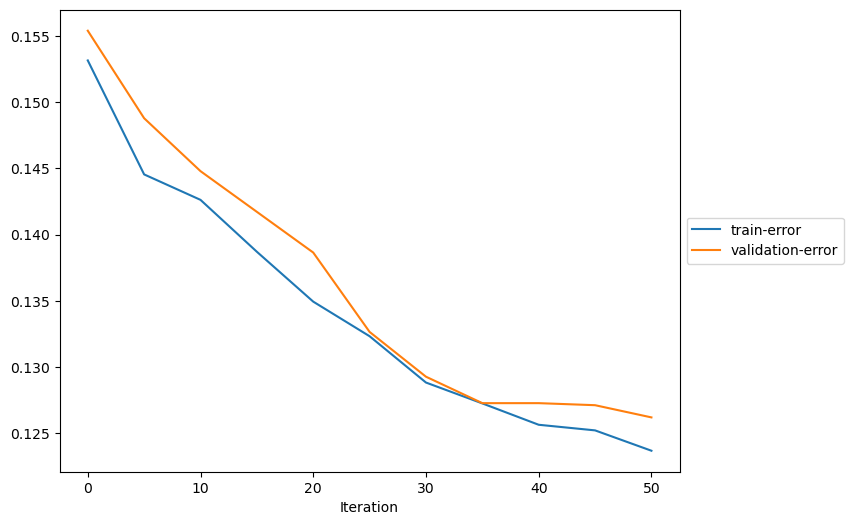

In [30]:
plot_collection(trial, "metrics")

In [32]:
trial.collection("metrics")

<class Collection: name=metrics>

In [34]:
from IPython.display import FileLink, FileLinks
display("Click link below to view the XGBoost Training report",
FileLink("CreateXgboostReport/xgboost_report.html"))


'Click link below to view the XGBoost Training report'

/home/ec2-user/SageMaker/CreateXgboostReport/xgboost_report.html

In [ ]:
%%time
import boto3
import sagemaker
from time import gmtime, strftime

sess = sagemaker.Session()

job_name = "xgboost-iris-debugger-" + strftime("%Y%m%d-%H-%M-%S", gmtime())
print("Training job", job_name)

linear = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.large",
    output_path=output_location,
    sagemaker_session=sagemaker_session,
)

# 5) Define hyperparameter ranges and invoke tuning job

Set the initial values for the hyperparameters

In [ ]:
# TODO: Use the set_hyperparameters function and set the initial hyperparameters on linear learner
# feature_dim=4, predictor_type='regressor', mini_batch_size=20

Lets use the Continous parameter range and define the `learning rate` and `wd`

In [ ]:
#TODO: Define the hyperparameter ranges
#1. 'learning_rate': ContinuousParameter(0.01, 0.2)
#2. 'wd': ContinuousParameter(0.0, 0.1)

1. Instead of manually configuring our hyper parameter values and training with SageMaker Training, we'll use Amazon SageMaker Automatic Model Tuning.
2. The code sample below shows you how to use the HyperParameterTuner. It accepts the hyperparameter ranges we set previously.
3. Based on your capacity, you can adjust the `max_jobs` and `max_parallel_jobs`
4. The goal of the tuning job is to minimize `rmse`
5. The tuning job will take 8 to 10 minutes to complete.

In [ ]:
# Create a HyperparameterTuner object
tuner = HyperparameterTuner(
    estimator=linear,
    objective_metric_name='validation:rmse',
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=[
        {'Name': 'validation:rmse', 'Regex': 'validation rmse=([0-9\\.]+)'}
    ],
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type='Minimize'
)

In [ ]:
#TODO: Initiate the tuner job by invoking the fit function.
#2. Pass the train_data and validation_data as input parameters